# Find genome-wide significant loci
- Inspired from: https://github.com/Nealelab/UK_Biobank_GWAS/blob/master/imputed-v2-gwas/Manhattan_plot.R
- does not work well with pan-UKBB


In [118]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [119]:
dir.create("pipeline/1.2.genomewide_significant_loci"     , showWarnings = FALSE)
dir.create("pipeline/1.2.genomewide_significant_loci/loci", showWarnings = FALSE)


# Filter manifest

In [120]:
infiles               = list.files("pipeline/1.1.sumstats/sumstats", pattern = "bgz$")
manifest              = fread("input/sumstats_manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest              = manifest[ manifest$filename %in% infiles,]
manifest$sumstat_file = paste(getwd(), "pipeline", "1.1.sumstats", "sumstats", manifest$filename, sep = "/")
manifest$id           = sub(".tsv.bgz", "", manifest$filename)
rownames(manifest)    = manifest$id

manifest   = manifest[ !manifest$description %in% c("K57 Diverticular disease of intestine", "Cataract", "M16 Coxarthrosis [arthrosis of hip]"), ]


In [123]:
populations = c('AFR','AMR','CSA','EAS','EUR','MID')

In [121]:
manifest$name = unlist(lapply(manifest$description, function(x){unlist(strsplit(x, ","))[[1]]}))
manifest[ manifest$description == "Treatment/medication code", "name"] = manifest[ manifest$description == "Treatment/medication code", "coding_description"]
manifest[ manifest$phenocode   == "LDLC"                     , "name"] = "LDL adjusted by medication"

In [133]:
manifest$n_cases_meta    = rowSums(manifest[, paste("n_cases"   , populations, sep = "_")], na.rm = TRUE)
manifest$n_controls_meta = rowSums(manifest[, paste("n_controls", populations, sep = "_")], na.rm = TRUE)


In [135]:
fwrite(manifest, "pipeline/1.1.sumstats/manifest.txt", sep = "\t", col.names = TRUE, row.names = TRUE)

# For each GWAS, get all variants with p-value <= 5e-8 and merge them

In [124]:
get_loci = function(id, manifest, populations, expand = 100000)
{
    message(id)
    
    infile    = manifest[id, "sumstat_file"]
    indata    = fread(cmd = paste("zcat", infile), sep = "\t", header = TRUE, data.table = FALSE)
    out       = indata
    out$min_p = apply(out[,colnames(out) %in% paste("pval", c("meta", populations), sep = "_")], 1, function(x){ifelse(min(x, na.rm = TRUE) <= 5e-8, yes = 1, no = 0)})
    out       = out[ out$min_p == 1, c("chr", "pos")]
    out$from  = unlist(lapply(out$pos - expand, function(x){max(0, x)}))
    out$to    =               out$pos + expand
    out$gwas  = id
    return(out)
}

vars              = as.data.frame(rbindlist(lapply(manifest$id, function(id){get_loci(id, manifest, populations, 100000)})), stringsAsFactors = FALSE)
vars              = vars[order(vars$chr, vars$pos), ]
vars_bed_unmerged = paste(getwd(), "pipeline", "1.2.genomewide_significant_loci", "loci", "loci.unmerged.bed", sep = "/")

fwrite(vars[,c("chr", "from", "to", "gwas")], vars_bed_unmerged, sep = "\t", col.names = FALSE, row.names = FALSE)

biomarkers-30600-both_sexes-irnt

biomarkers-30680-both_sexes-irnt

biomarkers-30690-both_sexes-irnt

biomarkers-30760-both_sexes-irnt

biomarkers-30780-both_sexes-irnt

biomarkers-30870-both_sexes-irnt

categorical-20003-both_sexes-1140861958

categorical-20003-both_sexes-1140866738

categorical-20003-both_sexes-1140879802

categorical-20003-both_sexes-1141146234

continuous-102-both_sexes-irnt

continuous-12336-both_sexes-irnt

continuous-12340-both_sexes-irnt

continuous-20022-both_sexes-irnt

continuous-21001-both_sexes-irnt

continuous-DBP-both_sexes-combined_medadj_irnt

continuous-LDLC-both_sexes-medadj_irnt

continuous-MAP-both_sexes-combined_medadj_irnt

continuous-PP-both_sexes-combined_medadj_irnt

continuous-SBP-both_sexes-combined_medadj_irnt

icd10-I20-both_sexes

icd10-I25-both_sexes

icd10-I26-both_sexes

icd10-I48-both_sexes

phecode-401-both_sexes

phecode-411.2-both_sexes

phecode-411.4-both_sexes



In [129]:
str(vars)

'data.frame':	829278 obs. of  5 variables:
 $ chr : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos : int  1065800 1066097 1066403 1066819 1066828 1066946 1066952 1066953 1067576 1068883 ...
 $ from: num  965800 966097 966403 966819 966828 ...
 $ to  : num  1165800 1166097 1166403 1166819 1166828 ...
 $ gwas: chr  "biomarkers-30680-both_sexes-irnt" "biomarkers-30680-both_sexes-irnt" "biomarkers-30680-both_sexes-irnt" "biomarkers-30680-both_sexes-irnt" ...


In [126]:
command_merge  = paste("bedtools", "merge", "-c", 4, "-o", "distinct", "-i", vars_bed_unmerged)
loci           = fread(cmd = command_merge, sep = "\t", header = FALSE, data.table = FALSE)
colnames(loci) = c("chrom", "from", "to", "ids")
loci$locus     = paste(loci$chrom, loci$from, loci$to, sep = "_")
rownames(loci) = loci$locus
loci$size      = loci$to - loci$from

loci2study = as.data.frame(matrix(0, nrow = nrow(loci), ncol = nrow(manifest), dimnames = list(loci$locus, manifest$id)))
for(locus in loci$locus)
{
    studies = unlist(strsplit(loci[locus, "ids"], ","))
    loci2study[locus, studies] = 1
}

fwrite(loci      , "pipeline/1.2.genomewide_significant_loci/loci.txt"      , sep = "\t", col.names = TRUE, row.names = TRUE)
fwrite(loci2study, "pipeline/1.2.genomewide_significant_loci/loci2study.txt", sep = "\t", col.names = TRUE, row.names = TRUE)


[1] 2045

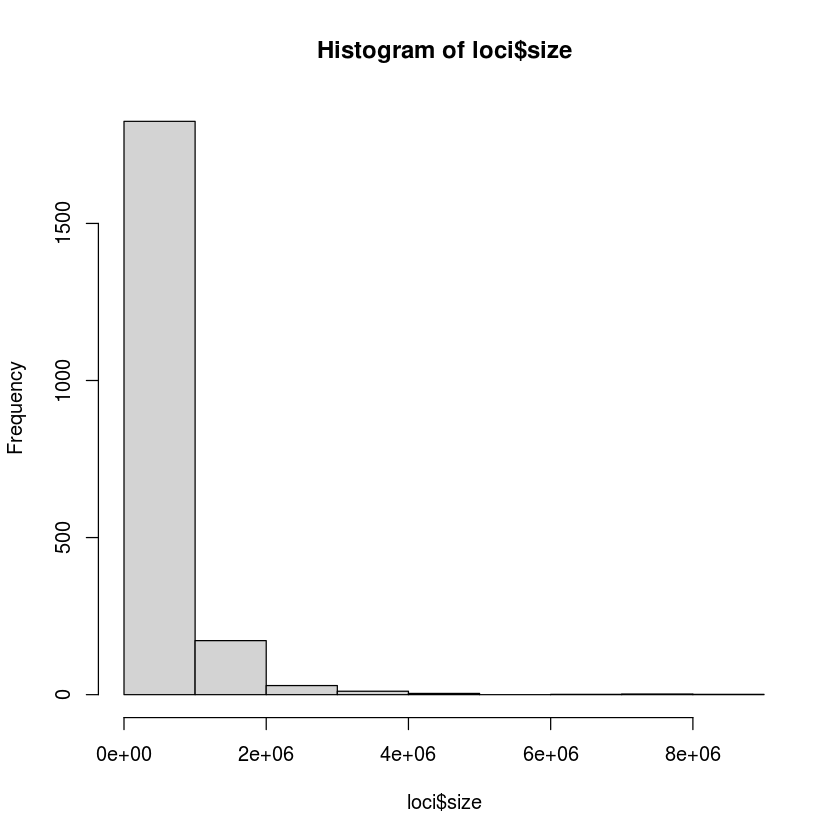

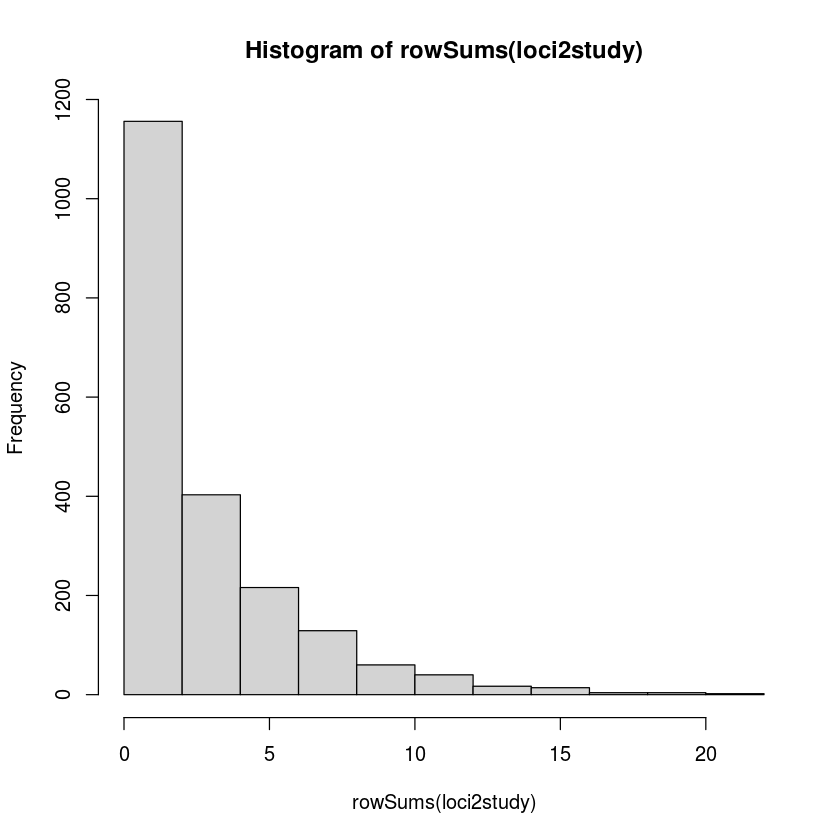

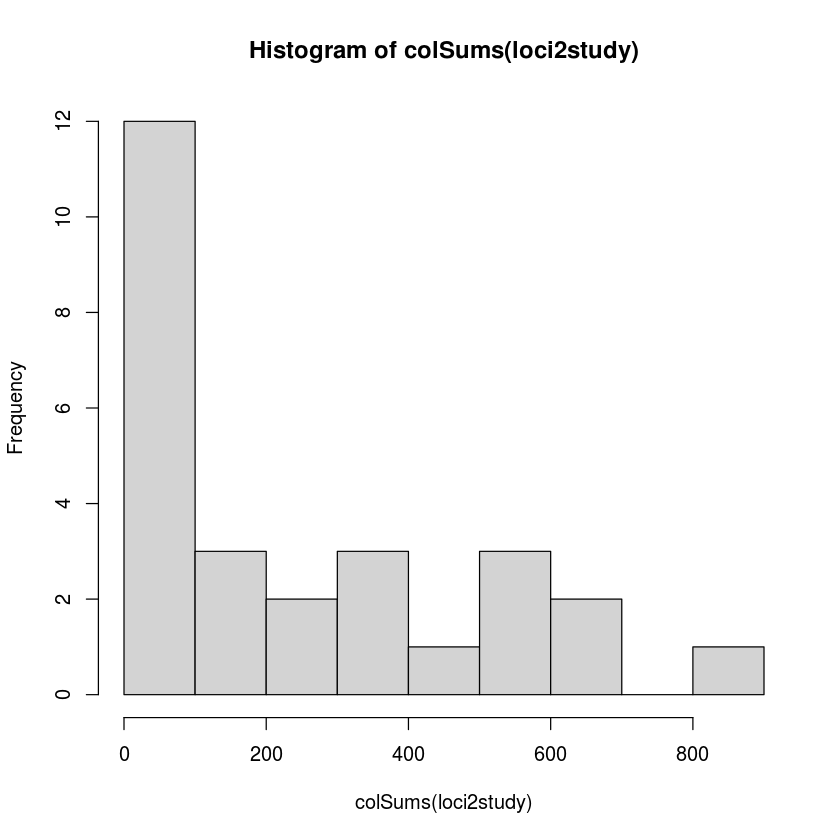

In [127]:
nrow(loci)
hist(loci$size)
hist(rowSums(loci2study))
hist(colSums(loci2study))


In [136]:
str(loci)

'data.frame':	2045 obs. of  6 variables:
 $ chrom: int  1 1 1 1 1 1 1 1 1 1 ...
 $ from : int  965800 2592477 2884087 3205016 6148182 6544723 7622595 8290051 9235173 9830927 ...
 $ to   : int  2544414 2853372 3089456 3441796 6406912 6879372 7901372 8995448 9556513 10934579 ...
 $ ids  : chr  "biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-2"| __truncated__ "continuous-21001-both_sexes-irnt" "phecode-411.2-both_sexes" "continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-bot"| __truncated__ ...
 $ locus: chr  "1_965800_2544414" "1_2592477_2853372" "1_2884087_3089456" "1_3205016_3441796" ...
 $ size : int  1578614 260895 205369 236780 258730 334649 278777 705397 321340 1103652 ...


In [137]:
loci["1_15163815_15363815",]

,chrom,from,to,ids,locus,size
,<int>,<int>,<int>,<chr>,<chr>,<int>
1_15163815_15363815,1,15163815,15363815,biomarkers-30760-both_sexes-irnt,1_15163815_15363815,200000
